# 1. Setup

In [1]:
import shutil

import contextily as ctx
from matplotlib_scalebar.scalebar import ScaleBar
from scipy.optimize import curve_fit

from utils import *

# 2. Prepare data

## 2.1. Accessibility by mode & purpose

Copy the processed data of BG geometries, opportunities distribution, and interzonal deterrence data from the accessibility project folder.

In [2]:
msa_names = ('San Francisco', 'Atlanta', 'Indianapolis')
msa_keys = tuple([x.replace(' ', '-').lower() for x in msa_names])

In [3]:
inroot = Path('../../access/data')
outroot = mkdir('../data/access')

### 2.1.1. Block groups

In [4]:
zones = gpd.read_parquet(outroot / 'zones.parquet').set_crs(CRS_M).disp()

8,514 rows x 4 cols; Memory: 1.2 MiB; CRS: EPSG:3857


,region,geoid,geometry,popu
,<object>,<object>,<geometry>,<float64>
0,san-francisco,060014001001,"POLYGON ((-13608463.772251 4563242.954634, -13...",1963.0


### 2.1.2. Opportunities

In [5]:
opp = pd.read_parquet(inroot / 'opport/opportunities.parquet')
opp['purpose'] = opp.kind.map(D(total='Work', overall='Non-work'))
opp = opp[['geoid', 'purpose', 'opport']]
opp = opp.dropna().merge(zones['geoid']).disp()
opp.to_parquet(outroot / 'opportunities.parquet')

16,642 rows x 3 cols; Memory: 2.2 MiB


,geoid,purpose,opport
,<object>,<object>,<int32>
0,060014001001,Work,324


### 2.1.3. Distances

In [6]:
# for msa, mode in it.product(msa_keys, ['drive', 'walk', 'bike']):
#     path = inroot / f'od_cost/osrm/msa/{msa}/bg_{mode}_2020.parquet'
#     shutil.copy(path, mkfile(outroot / f'dist/{msa}_{mode}.parquet'))

### 2.1.4. Impedance function params

In [7]:
def get_imped_params(func=lambda x, b: np.exp(-b * x)):
    trips = pd.read_parquet(DATA / 'trips2.parquet')
    def get_params(df):
        y = df['Time'].clip(0, 120)
        y, x = np.histogram(y, bins=np.arange(0, 121))
        y = (1 - (y / y.sum()).cumsum()).clip(0)
        beta = curve_fit(func, x[1:], y)[0][0]
        return D(beta=beta)
    res = [D(Mode='Overall', Purpose='Overall') | get_params(trips)]
    for (mode, purpose), df in trips.groupby(['Mode', 'Purpose']):
        if mode == 'Transit': continue
        res.append(D(Mode=mode, Purpose=purpose) | get_params(df))
    res = Pdf(res)
    return res

params = get_imped_params().disp(None)

7 rows x 3 cols; Memory: 0.0 MiB


,Mode,Purpose,beta
,<object>,<object>,<float64>
0,Overall,Overall,0.053918
1,Drive,Work,0.039113
2,Drive,Non-work,0.05878
3,Walk,Work,0.068474
4,Walk,Non-work,0.059595
5,Bike,Work,0.048823
6,Bike,Non-work,0.04504


## 2.2. Compute accessibility

### 2.2.1. At BG level

In [8]:
def get_access_bg(params=params, outroot=outroot, overwrite=False):
    outpath = outroot / 'comparison_time.parquet'
    if outpath.exists() and not overwrite:
        return pd.read_parquet(outpath)
    zones = pd.read_parquet(outroot / 'zones.parquet')
    opp = pd.read_parquet(outroot / 'opportunities.parquet')
    opp = opp.merge(zones[['region', 'geoid']])
    res = []
    overall, params = params.iloc[0]['beta'], params.iloc[1:]
    pbar = tqdm(list(it.product(opp.region.unique(), params.Mode.unique())))
    for rgn, mode in pbar:
        msa = rgn.replace('-', ' ').title()
        pbar.set_description(f'{msa} → {mode}')
        fpath = outroot / f'dist/{rgn}_{mode.lower()}.parquet'
        dist = pd.read_parquet(fpath).rename(
            columns=D(src_geoid='geoid', trg_geoid='trg'))
        dist.duration /= 60 # s to min
        for purpose in params.Purpose.unique():
            df = opp.query(f'region=="{rgn}" & purpose=="{purpose}"')
            df = dist.merge(df.rename(columns=D(geoid='trg')))
            df = df[['geoid', 'duration', 'opport']]
            row = params.query(f'Mode=="{mode}" & '
                               f'Purpose=="{purpose}"').iloc[0]
            for thresh in tqdm(np.arange(5, 90 + 1, 5), leave=False):
                d = df[df.duration <= thresh].reset_index(drop=1)
                # d['general'] = d.opport * np.exp(-overall.B0 * (d.duration ** overall.B1))
                # d['correct'] = d.opport * np.exp(-row.B0 * (d.duration ** row.B1))
                d['general'] = d.opport * np.exp(-overall * d.duration)
                d['correct'] = d.opport * np.exp(-row.beta * d.duration)
                d = d.merge(zones[['geoid', 'popu']], on='geoid')
                d = (d.groupby('geoid')[['popu', 'general', 'correct']]
                     .sum().astype(np.float32).reset_index())
                d['pct_diff'] = (d.correct / (d.general + 1e-6) - 1) * 100
                res.append(d.assign(
                    msa=msa, mode=mode, purpose=purpose, thresh=thresh))
    res = pd.concat(res).astype(D(
        geoid=CAT, msa=CAT, mode=CAT, purpose=CAT, thresh=CAT))
    res.to_parquet(mkfile(outpath))
    return res

xs_bg = get_access_bg(overwrite=0).disp() # t=2:49
# x = get_access_bg(overwrite=1); x

918,039 rows x 9 cols; Memory: 33.2 MiB


,geoid,popu,general,correct,pct_diff,msa,mode,purpose,thresh
,<category>,<float32>,<float32>,<float32>,<float32>,<category>,<category>,<category>,<int64>
0,060014001001,9815.0,1116.177246,1169.654541,4.791117,San Francisco,Drive,Work,5


In [9]:
xs_bg.groupby(['mode', 'purpose']).correct.mean()

mode   purpose 
Bike   Non-work      1532.230835
       Work         39622.933594
Drive  Non-work      8381.791992
       Work        379877.906250
Walk   Non-work       221.497711
       Work          5127.625977
Name: correct, dtype: float32

### 2.2.2. At MSA level

In [10]:
def get_access_msa(xs=xs_bg):
    res = []
    for comb, df in xs.groupby(['msa', 'mode', 'purpose', 'thresh']):
        correct = (df.correct * df.popu).sum() / df.popu.sum()
        general = (df.general * df.popu).sum() / df.popu.sum()
        pct_diff = (correct / general - 1) * 100
        comb = D(zip('msa mode purpose thresh'.split(), comb))
        res.append(comb | D(pct_diff=pct_diff))
    res = Pdf(res)
    return res

xs_diff_msa = get_access_msa().disp()

324 rows x 5 cols; Memory: 0.1 MiB


,msa,mode,purpose,thresh,pct_diff
,<object>,<object>,<object>,<int64>,<float64>
0,Atlanta,Bike,Non-work,5,1.396167


In [21]:
def fig_access_comparison(xs_bg=xs_bg, zones=zones, dpi=150, cmap='terrain_r'):
    xs = xs_bg.query('msa=="Indianapolis" & mode=="Drive" & '
                     'purpose=="Work" & thresh==90')
    
    # zones = zones[['geoid', 'geometry']].assign(area=zones.area * SQM2SQMI)
    # xs = zones.merge(xs, on='geoid')
    # xs['pop_density'] = xs
    return xs

x = fig_access_comparison(); x

,geoid,popu,general,correct,pct_diff,msa,mode,purpose,thresh
0,180118101001,1862901.0,101618.843750,183332.937500,80.412338,Indianapolis,Drive,Work,90
1,180118101002,1117548.0,64697.308594,131552.234375,103.334953,Indianapolis,Drive,Work,90
2,180118101003,1619352.0,94127.789062,173563.312500,84.391151,Indianapolis,Drive,Work,90
3,180118102001,1206986.0,61700.066406,127279.031250,106.286690,Indianapolis,Drive,Work,90
4,180118102002,1473355.0,38838.890625,90075.992188,131.922150,Indianapolis,Drive,Work,90
...,...,...,...,...,...,...,...,...,...
1420,181590204013,1416506.0,48496.761719,103136.242188,112.666252,Indianapolis,Drive,Work,90
1421,181590204014,711200.0,51376.199219,107498.390625,109.237717,Indianapolis,Drive,Work,90
1422,181590204015,514402.0,50326.925781,105941.148438,110.505890,Indianapolis,Drive,Work,90
1423,181590204021,1405371.0,39554.730469,88383.140625,123.445175,Indianapolis,Drive,Work,90


  0%|          | 0/3 [00:00<?, ?it/s]

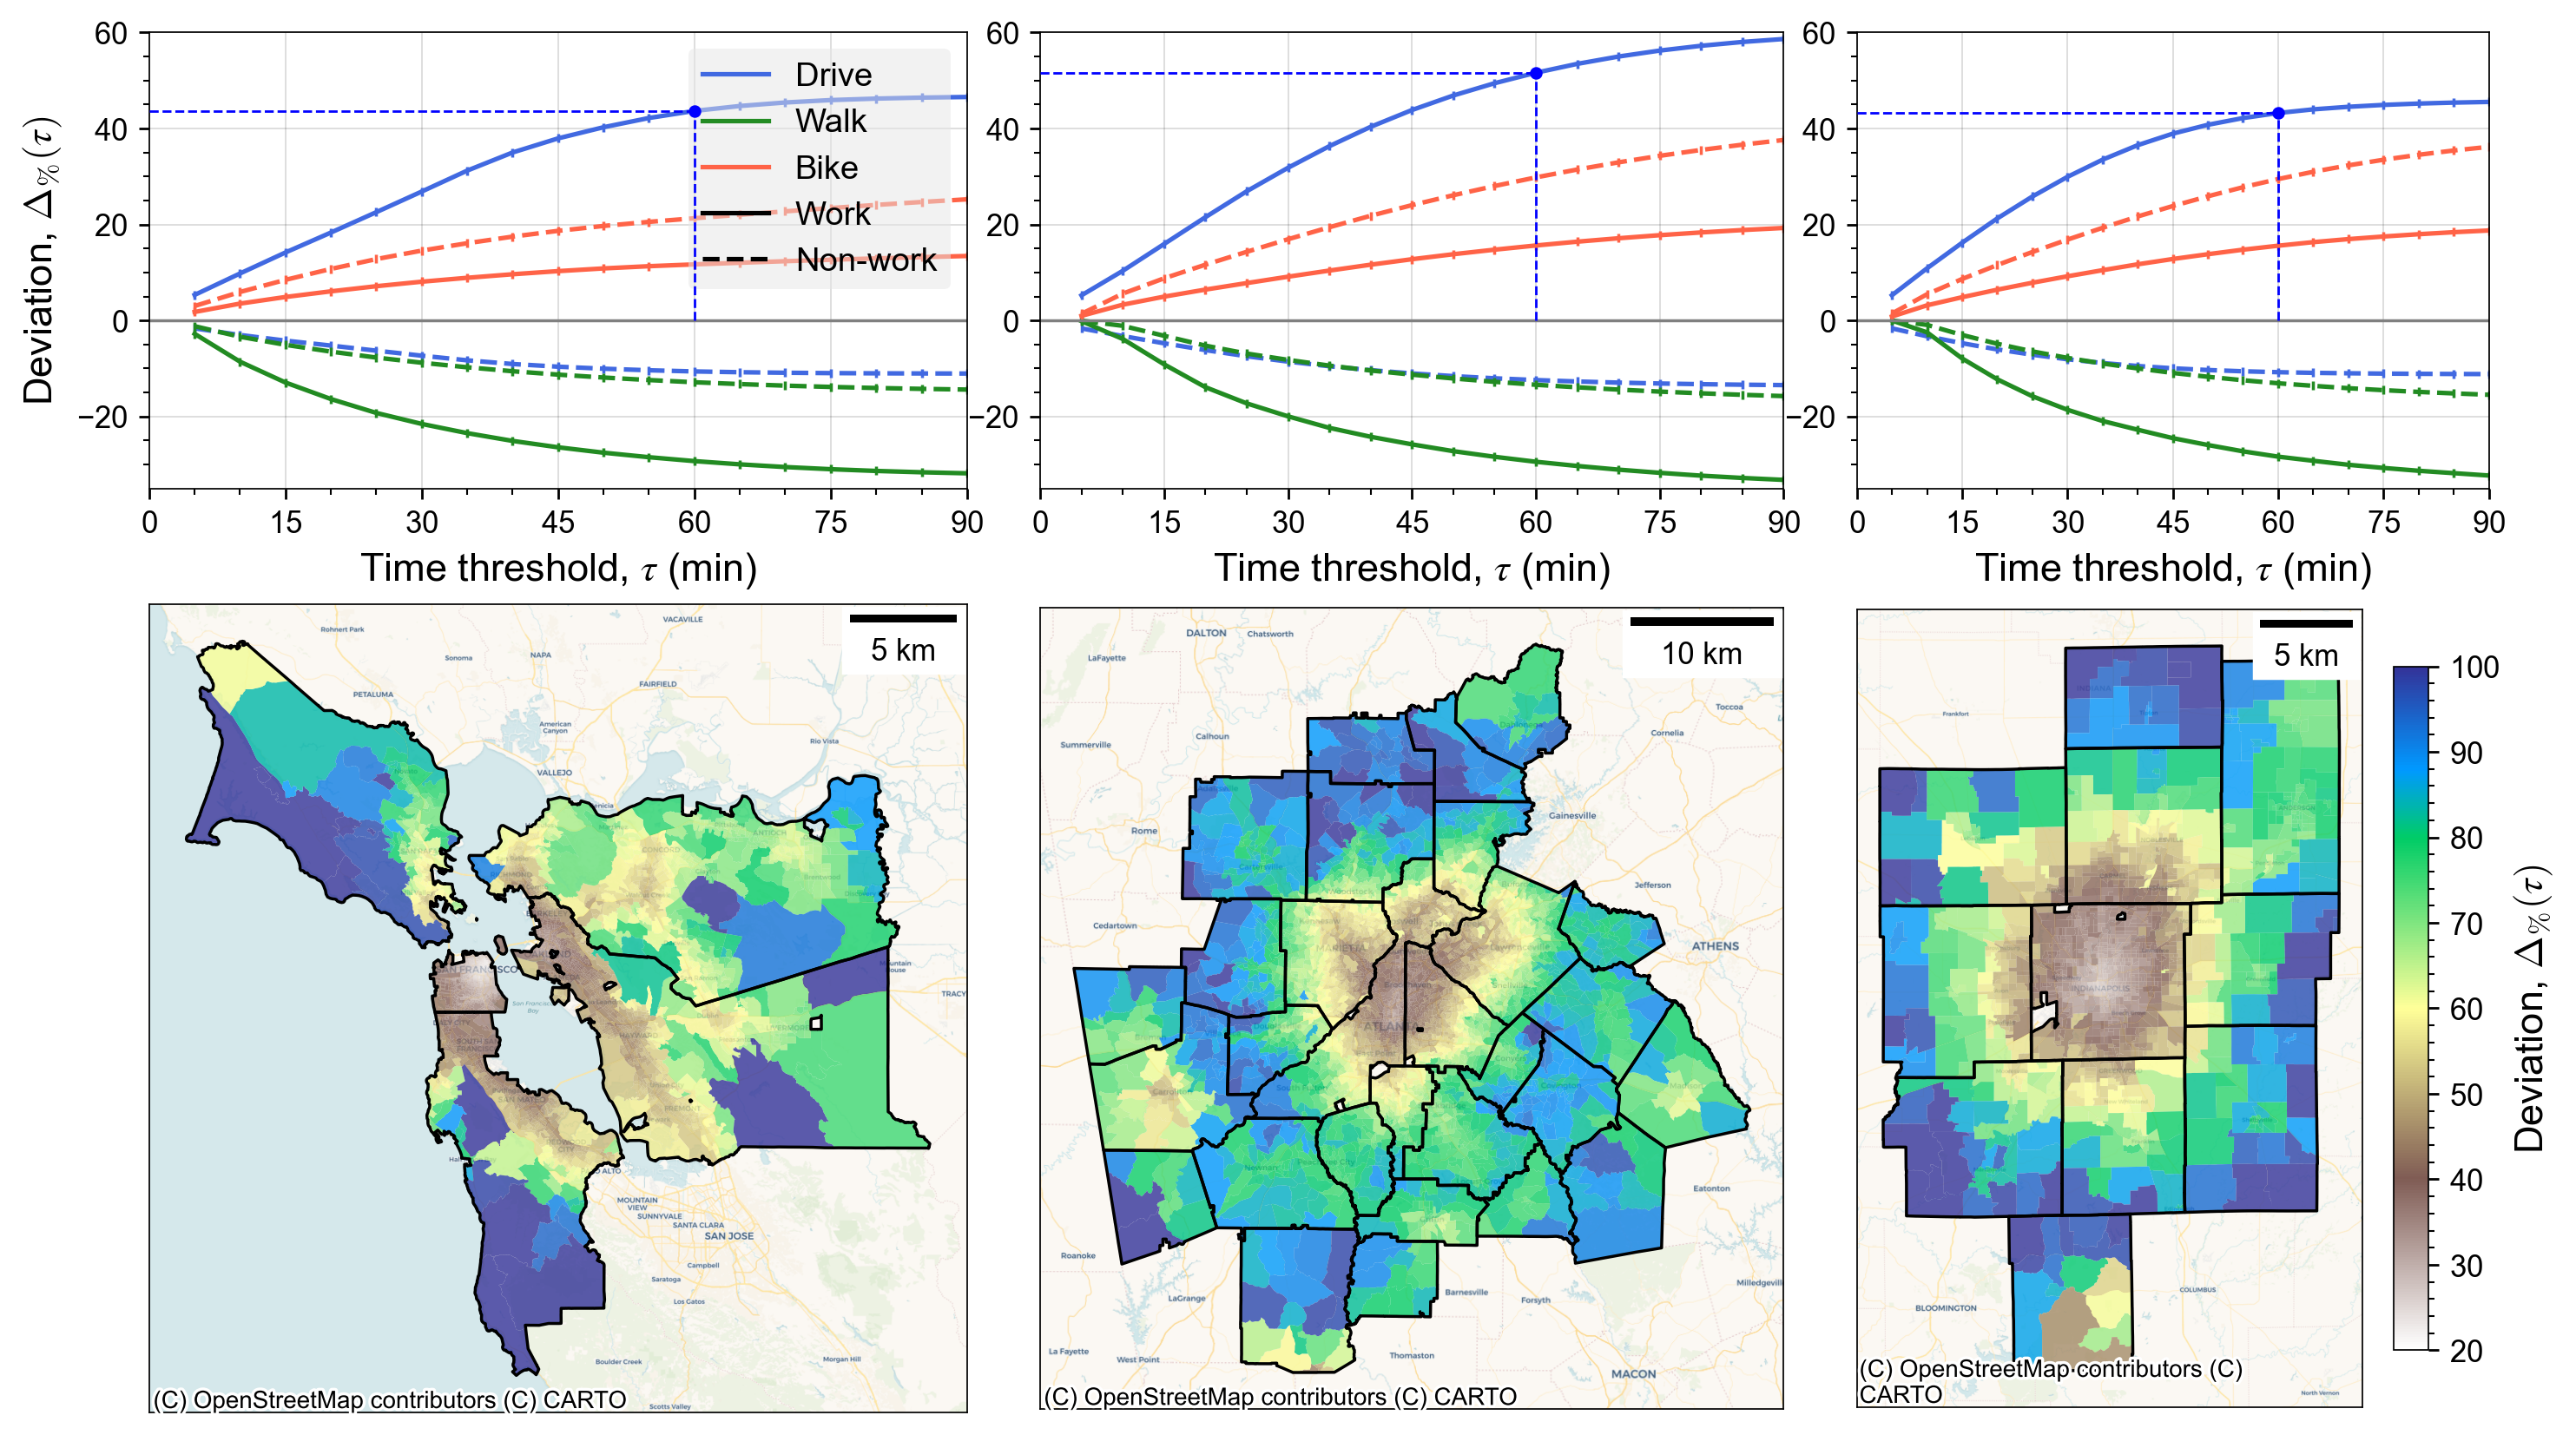

In [12]:
def fig_access_comparison(xs_bg=xs_bg, xs_msa=xs_diff_msa,
                          dpi=150, cmap='terrain_r'):
    _, axes = plt.subplots(2, 3, figsize=(12, 8), dpi=dpi,
                           gridspec_kw=D(width_ratios=[1.1, 1, 0.85],
                                         height_ratios=[2, 6]))
    mode_colors = D(Drive='royalblue', Walk='forestgreen', Bike='tomato')
    purp_ls = {'Work': '-', 'Non-work': '--'}
    xs = xs_bg.query('mode=="Drive" & purpose=="Work" & thresh==60')
    zones = gpd.read_parquet(outroot / 'zones.parquet')
    msas = ('San Francisco', 'Atlanta', 'Indianapolis')
    ylabel = 'Deviation, $\Delta_{\%}(τ)$'
    line = lambda l, **kw: mpl.lines.Line2D([0], [0], label=l, **kw)
    for j, msa in enumerate(tqdm(msas)):
        ## Top row: Percent change by threshold
        ax = pplot(axes[0, j], xlab='Time threshold, $τ$ (min)',
                   xlim=(0, 90), ylim=(-35, 60))
        df = xs_msa.query(f'msa=="{msa}"')
        for mode, color in mode_colors.items():
            df2 = df[df['mode'] == mode]
            for purpose, ls in purp_ls.items():
                d = df2.query(f'purpose=="{purpose}"')
                ax.plot(d.thresh, d.pct_diff, '|' + ls, lw=1.5,
                        markersize=3, color=color)
                if mode == 'Drive' and purpose == 'Work':
                    y = d.set_index('thresh').loc[60].pct_diff
                    ax.scatter(60, y, marker='o', s=10, color='b', zorder=10)
                    ax.plot([0, 60], [y] * 2, 'b--', lw=0.8, zorder=10)
                    ax.plot([60] * 2, [0, y], 'b--', lw=0.8, zorder=10)
        ax.axhline(0, color='grey', lw=1)
        ax.set_xticks(np.arange(0, 91, 15))
        ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))
        if j == 0:
            ax.set_ylabel(ylabel)
            ax.legend(loc='upper right', handles=[
                *[line(k, color=v) for k, v in mode_colors.items()],
                *[line(k, color='k', ls=v) for k, v in purp_ls.items()]])
        ## Bottom row: Map
        df = zones[zones.region == msa.replace(' ', '-').lower()]
        df = df[['geoid', 'geometry']].merge(xs)
        cnty = df.assign(geoid=df.geoid.str[:5])[
            ['geoid', 'geometry']].dissolve('geoid')
        ax = pplot(axes[1, j])
        df.plot(ax=ax, column='pct_diff', cmap=cmap, vmin=20, vmax=100, alpha=0.8,
                legend=j == 2, legend_kwds=D(shrink=0.5, label=ylabel))
        cnty.plot(ax=ax, ec='k', lw=1, fc='none')
        ctx.add_basemap(ax=ax, crs=CRS_M, source=ctx.providers.CartoDB.Voyager)
        ax.add_artist(ScaleBar(0.2))
        ax.tick_params(axis='both', which='both', left=0, bottom=0)
        ax.set_xticks([]); ax.set_yticks([])
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=-0.18)

x = fig_access_comparison(dpi=250); x # t=0:15

## 2.3. Opportunities map

In [19]:
zones = gpd.read_parquet(outroot / 'zones.parquet').set_crs(CRS_M).disp()

8,514 rows x 4 cols; Memory: 1.2 MiB; CRS: EPSG:3857


,region,geoid,geometry,popu
,<object>,<object>,<geometry>,<float64>
0,san-francisco,060014001001,"POLYGON ((-13608463.772251 4563242.954634, -13...",1963.0


In [20]:
(zones.assign(area=zones.area * SQM2SQMI)
 .groupby('region')[['area','popu']].sum()
 .assign(pop_density=lambda df: df.popu / df['area']))

,area,popu,pop_density
region,,,
atlanta,12896.615600,6035460.0,467.987896
indianapolis,6964.238822,2067684.0,296.900214
san-francisco,4136.520603,4672587.0,1129.593552
